## Experiment F02: undersampeld radial with Compressed Sensing (CS)

In [10]:
experiment_id = 'exF02_undersampled_radial'

import MRzeroCore as mr0
import numpy as np
import math
import torch
import matplotlib.pyplot as plt
import pypulseq as pp

### 1) Setup system

In [11]:
system = pp.Opts(max_grad=28, grad_unit='mT/m', max_slew=150, slew_unit='T/m/s',
                 rf_ringdown_time=20e-6, rf_dead_time=100e-6, adc_dead_time=20e-6,
                 grad_raster_time=50*10e-6)

fov = 1000e-3 
slice_thickness=8e-3

Nread = 64    # frequency encoding steps/samples
Nphase = 32   # phase encoding steps/samples

### 2) Construct the Sequence

In [22]:
seq = pp.Sequence()
rf_phase = 180
rf_inc = 180

rf0 = pp.make_sinc_pulse(flip_angle=6/2 * math.pi / 180, duration=1e-3,
                         slice_thickness=slice_thickness, apodization=0.5,
                         time_bw_product=4, system=system)                      
rf1 = pp.make_sinc_pulse(flip_angle=6 * math.pi / 180, duration=1e-3,
                         slice_thickness=slice_thickness, apodization=0.5,
                         time_bw_product=4, system=system)

gx_tmp = pp.make_trapezoid(channel='x', flat_area=Nread, flat_time=5e-3, system=system)
adc = pp.make_adc(num_samples=Nread, duration=5e-3, phase_offset=0*np.pi/180,
                  delay=gx_tmp.rise_time, system=system)

seq.add_block(rf0)
seq.add_block(pp.make_delay(3e-3))

for ii in range(-Nphase//2, Nphase//2):  # e.g. -64:63
    rf1.phase_offset = rf_phase / 180 * np.pi   # set current rf phase
    
    adc.phase_offset = rf_phase / 180 * np.pi  # follow with ADC
    rf_phase = divmod(rf_phase + rf_inc, 360.0)[1]        # increment additional pahse

    seq.add_block(rf1)
    
    if ii != 0:
        gx = pp.make_trapezoid(channel='x', flat_area=-Nread*np.sin(ii/Nphase*np.pi), flat_time=5e-3, system=system)
    else:
        # pulseq 1.3.1post1 thinks flat_area=0 means it was not set
        gx = pp.make_trapezoid(channel='x', area=0, flat_time=5e-3, system=system)
    gy = pp.make_trapezoid(channel='y', flat_area=Nread*np.cos(ii/Nphase*np.pi), flat_time=5e-3, system=system)
    
    gx_pre = pp.make_trapezoid(channel='x', area=-gx.area / 2, duration=1e-3, system=system)
    gy_pre = pp.make_trapezoid(channel='y', area=-gy.area / 2, duration=1e-3, system=system)
    
    
    seq.add_block(gx_pre,gy_pre)
    seq.add_block(adc,gx,gy)
    # seq.add_block(adc,gx,gy)
    seq.add_block(gx_pre,gy_pre)
    # seq.add_block(make_delay(10))

### 3) Check, Plot and Write the sequence as .seq

Timing check passed successfully


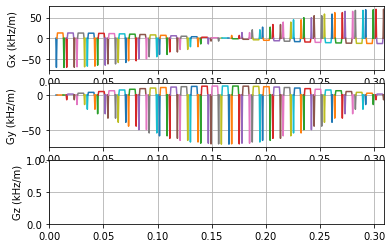

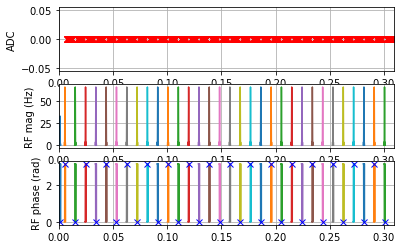

In [13]:
ok, error_report = seq.check_timing()  # Check whether the timing of the sequence is correct
if ok:
    print('Timing check passed successfully')
else:
    print('Timing check failed. Error listing follows:')
    [print(e) for e in error_report]

# PLOT sequence
seq.plot()

# Prepare the sequence output for the scanner
seq.set_definition('FOV', [fov, fov, slice_thickness]*1000)
seq.set_definition('Name', 'gre')
seq.write('out/external.seq')
seq.write('out/' + experiment_id +'.seq')

### 4) Simulate the .seq file

VoxelGridPhantom
FOV: base * rel = tensor([0.1920, 0.1920, 0.1920]) * tensor([1., 1., 1.]) = tensor([0.1920, 0.1920, 0.1920])


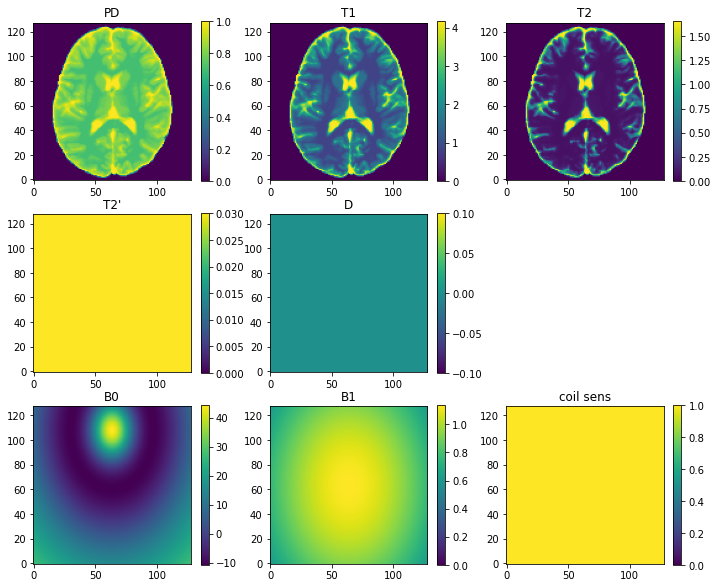

C:\Users\endresjn\Documents\MRzero\MRzero-Core\python\MRzeroCore\phantom\voxel_grid_phantom.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(shape, device=self.PD.device) / 2,


In [14]:
sz = [64, 64]

if 1:
    # (i) load a phantom object from file
    obj_p = mr0.VoxelGridPhantom.brainweb("subject05.npz")
    obj_p = obj_p.interpolate(128, 128, 32).slices([16])
    # Manipulate loaded data
    obj_p.T2dash[:] = 30e-3
    obj_p.D *= 0
else:
    # or (ii) set phantom  manually to a pixel phantom. Coordinate system is [-0.5, 0.5]^3
    obj_p = mr0.CustomVoxelPhantom(
        pos=[[-0.4, -0.4, 0], [-0.4, -0.2, 0], [-0.3, -0.2, 0], [-0.2, -0.2, 0], [-0.1, -0.2, 0]],
        PD=[1.0, 1.0, 0.5, 0.5, 0.5],
        T1=1.0,
        T2=0.1,
        T2dash=0.1,
        D=0.0,
        voxel_size=0.1,
        voxel_shape="box"
    )

obj_p.plot()
# Convert Phantom into simulation data
obj_p = obj_p.build()

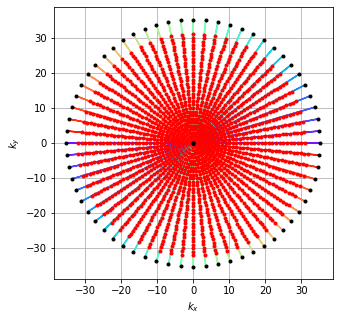

Calculating repetition 33 / 33 - done


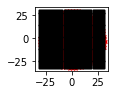

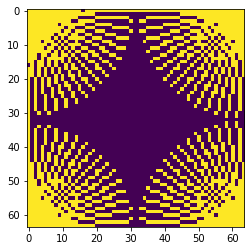

In [15]:
signal, kspace_loc = mr0.sim_external(obj=obj_p, plot_seq_k=[0,1])   
# plot the result into the ADC subplot
# seq.plot(signal=signal.numpy())
          
kspace_adc=torch.reshape((signal),(Nphase,Nread)).clone().t()
spectrum=kspace_adc

space = torch.zeros_like(spectrum)

if 0: # FFT
    # fftshift
    spectrum=torch.fft.fftshift(spectrum,0); spectrum=torch.fft.fftshift(spectrum,1)
    #FFT
    space = torch.fft.ifft2(spectrum)
    # fftshift
    space=torch.fft.ifftshift(space,0); space=torch.fft.ifftshift(space,1)


if 1: # NUFFT
    import scipy.interpolate
    grid = kspace_loc[:,:2]
    Nx=64
    Ny=64
    
    X, Y = np.meshgrid(np.linspace(0,Nx-1,Nx) - Nx / 2, np.linspace(0,Ny-1,Ny) - Ny/2)
    grid = np.double(grid.numpy())
    grid[np.abs(grid) < 1e-3] = 0
    
    plt.subplot(347); plt.plot(grid[:,0].ravel(),grid[:,1].ravel(),'rx',markersize=3);  plt.plot(X,Y,'k.',markersize=2);
    plt.show()
    
    spectrum_resampled_x = scipy.interpolate.griddata((grid[:,0].ravel(), grid[:,1].ravel()), np.real(signal.ravel()), (X, Y), method='cubic')
    spectrum_resampled_y = scipy.interpolate.griddata((grid[:,0].ravel(), grid[:,1].ravel()), np.imag(signal.ravel()), (X, Y), method='cubic')

    kspace_r=spectrum_resampled_x+1j*spectrum_resampled_y
    kspace_r[np.isnan(kspace_r)] = 0
    
    
    
    # k-space sampling pattern needed for the CS algorithms
    pattern_resampled=np.zeros([sz[0],sz[1]])
    gridx=grid[:,0].ravel()
    gridy=grid[:,1].ravel()
    for ii in range(len(gridx)):
        pattern_resampled[int(gridx[ii]),int(gridy[ii])]=1
    plt.imshow(pattern_resampled)
    plt.show()
    # end sampling pattern

### 5) Compressed Sensing MR reconstruction of undersampled signal

#### 5.1) Function definitions

In [16]:
import pywt
from skimage.restoration import denoise_tv_chambolle


def shrink(coeff, epsilon):
	shrink_values = (abs(coeff) < epsilon) 
	high_values = coeff >= epsilon
	low_values = coeff <= -epsilon
	coeff[shrink_values] = 0
	coeff[high_values] -= epsilon
	coeff[low_values] += epsilon

# help: https://www2.isye.gatech.edu/~brani/wp/kidsA.pdf
for family in pywt.families():
    print("%s family: " % family + ', '.join(pywt.wavelist(family)))
print(pywt.Wavelet('haar'))


def waveletShrinkage(current, epsilon):
	# Compute Wavelet decomposition
	cA, (cH, cV, cD)  = pywt.dwt2(current, 'haar')
	#Shrink
	shrink(cA, epsilon)
	shrink(cH, epsilon)
	shrink(cV, epsilon)
	shrink(cD, epsilon)
	wavelet = cA, (cH, cV, cD)
	# return inverse WT
	return pywt.idwt2(wavelet, 'haar')


def updateData(k_space, pattern, current, step,i):
    # go to k-space
    update = np.fft.ifft2(np.fft.fftshift(current))
    # compute difference
    update = k_space - (update * pattern)
    print("i: {}, consistency RMSEpc: {:3.6f}".format(i,np.abs(update[:]).sum()*100))
    # return to image space
    update = np.fft.fftshift(np.fft.fft2(update))
    update = current + (step * update)  # improve current estimation by consitency
    return update

haar family: haar
db family: db1, db2, db3, db4, db5, db6, db7, db8, db9, db10, db11, db12, db13, db14, db15, db16, db17, db18, db19, db20, db21, db22, db23, db24, db25, db26, db27, db28, db29, db30, db31, db32, db33, db34, db35, db36, db37, db38
sym family: sym2, sym3, sym4, sym5, sym6, sym7, sym8, sym9, sym10, sym11, sym12, sym13, sym14, sym15, sym16, sym17, sym18, sym19, sym20
coif family: coif1, coif2, coif3, coif4, coif5, coif6, coif7, coif8, coif9, coif10, coif11, coif12, coif13, coif14, coif15, coif16, coif17
bior family: bior1.1, bior1.3, bior1.5, bior2.2, bior2.4, bior2.6, bior2.8, bior3.1, bior3.3, bior3.5, bior3.7, bior3.9, bior4.4, bior5.5, bior6.8
rbio family: rbio1.1, rbio1.3, rbio1.5, rbio2.2, rbio2.4, rbio2.6, rbio2.8, rbio3.1, rbio3.3, rbio3.5, rbio3.7, rbio3.9, rbio4.4, rbio5.5, rbio6.8
dmey family: dmey
gaus family: gaus1, gaus2, gaus3, gaus4, gaus5, gaus6, gaus7, gaus8
mexh family: mexh
morl family: morl
cgau family: cgau1, cgau2, cgau3, cgau4, cgau5, cgau6, cgau7, 

#### 5.2) Preparation and conventional fully sampled reconstruction

In [17]:
kspace_full = np.fft.ifftshift(kspace_r)  # high  frequencies centered as FFT needs it

kspace=kspace_full
recon_nufft = (np.fft.fftshift(np.fft.fft2(kspace_full))) # fully sampled recon

#### 5.3) Undersampling and undersampled reconstruction

i: 0, consistency RMSEpc: 528136.784089
i: 0, consistency RMSEpc: 0.000000
i: 1, consistency RMSEpc: 232994.413426
i: 2, consistency RMSEpc: 217475.794491
i: 3, consistency RMSEpc: 203760.620849
i: 4, consistency RMSEpc: 191696.042246
i: 5, consistency RMSEpc: 181050.628380
i: 6, consistency RMSEpc: 171782.049484
i: 7, consistency RMSEpc: 164011.937885
i: 8, consistency RMSEpc: 158581.286230
i: 9, consistency RMSEpc: 155981.515376
i: 10, consistency RMSEpc: 154337.171673
i: 11, consistency RMSEpc: 153669.916086
i: 12, consistency RMSEpc: 152988.359379
i: 13, consistency RMSEpc: 152712.632485
i: 14, consistency RMSEpc: 152249.300364
i: 15, consistency RMSEpc: 152084.028694
i: 16, consistency RMSEpc: 151736.832721
i: 17, consistency RMSEpc: 151600.748233
i: 18, consistency RMSEpc: 151304.805372
i: 19, consistency RMSEpc: 151181.615584
i: 20, consistency RMSEpc: 150923.911593
i: 21, consistency RMSEpc: 150807.354553
i: 22, consistency RMSEpc: 150575.743150
i: 23, consistency RMSEpc: 15046

C:\Users\endresjn\AppData\Local\Temp/ipykernel_20516/1681385487.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  all_iter[:,:,i]=current


i: 153, consistency RMSEpc: 144681.543568
i: 154, consistency RMSEpc: 144669.928034
i: 155, consistency RMSEpc: 144652.429695
i: 156, consistency RMSEpc: 144640.852948
i: 157, consistency RMSEpc: 144623.609352
i: 158, consistency RMSEpc: 144612.104468
i: 159, consistency RMSEpc: 144595.124951
i: 160, consistency RMSEpc: 144583.724509
i: 161, consistency RMSEpc: 144567.025544
i: 162, consistency RMSEpc: 144555.772874
i: 163, consistency RMSEpc: 144539.707425
i: 164, consistency RMSEpc: 144528.839999
i: 165, consistency RMSEpc: 144513.030494
i: 166, consistency RMSEpc: 144502.287876
i: 167, consistency RMSEpc: 144486.734948
i: 168, consistency RMSEpc: 144476.118342
i: 169, consistency RMSEpc: 144460.822626
i: 170, consistency RMSEpc: 144450.334679
i: 171, consistency RMSEpc: 144435.297500
i: 172, consistency RMSEpc: 144424.942660
i: 173, consistency RMSEpc: 144410.166412
i: 174, consistency RMSEpc: 144399.950303
i: 175, consistency RMSEpc: 144385.437388
i: 176, consistency RMSEpc: 144375

C:\Users\endresjn\AppData\Local\Temp/ipykernel_20516/1681385487.py:62: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(abs(np.fft.fftshift(kspace_full)))); plt.ylabel('kspace_nufft')
C:\Users\endresjn\AppData\Local\Temp/ipykernel_20516/1681385487.py:65: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(abs(np.fft.fftshift((kspace))))); plt.ylabel('kspace*pattern')


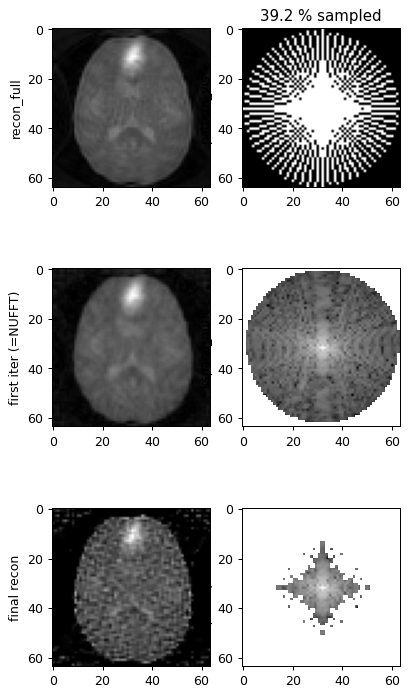

In [21]:
# kspace_full= kspace_full/ np.linalg.norm(kspace_full[:])   # normalization of the data somethimes helps

# parameters of iterative reconstructio using total variation denoising  
denoising_strength = 5e-5
number_of_iterations = 8000

# parameters of random subsampling pattern
# percent = 0.25        # this is the amount of data that is randomly measured
# square_size = 16      # size of square in center of k-space 


# # generate a random subsampling pattern
# np.random.seed(np.random.randint(100))
# pattern = np.random.random_sample(kspace.shape)
# pattern=pattern<percent  # random data

# pattern[sz[0]//2-square_size//2:sz[0]//2+square_size//2,sz[0]//2-square_size//2:sz[0]//2+square_size//2] = 1   # square in center of k-space 
# pattern = np.fft.fftshift(pattern) # high  frequencies centered as kspace and as FFT needs it

pattern= pattern_resampled

kspace = kspace_full *pattern  # apply the undersampling pattern

actual_measured_percent =np.count_nonzero(pattern) / pattern.size *100  #  calculate the actually measured data in percent

## actual iterative reconstruction algorithm 
current = np.zeros(kspace.size).reshape(kspace.shape)
current_shrink = np.zeros(kspace.size).reshape(kspace.shape)
first = updateData(kspace, pattern, current, 1,0)
current_shrink=first
all_iter = np.zeros((kspace.shape[0],kspace.shape[1],number_of_iterations))

i = 0
while i < number_of_iterations:
    current = updateData(kspace, pattern, current_shrink, 0.1,i)
   
    current_shrink = denoise_tv_chambolle(abs(current), denoising_strength)
    # current_shrink = waveletShrinkage(abs(current), denoising_strength)
    
    all_iter[:,:,i]=current
    i = i + 1; 
		
## Plotting

pattern_vis = np.fft.fftshift(pattern * 256)

fig=plt.figure(figsize=(5, 10), dpi=90)
plt.subplot(321)
plt.set_cmap(plt.gray())
plt.imshow(abs(recon_nufft)); plt.ylabel('recon_full')
plt.subplot(322)
plt.set_cmap(plt.gray())
plt.imshow(abs(pattern_vis)); plt.ylabel("pattern_vis"); plt.title("{:.1f} % sampled".format(actual_measured_percent))
plt.subplot(323)
plt.set_cmap(plt.gray())
plt.imshow(abs(first)); plt.ylabel('first iter (=NUFFT)')
plt.subplot(325)
plt.set_cmap(plt.gray())
plt.imshow(abs(current_shrink)) ; plt.ylabel('final recon')
plt.subplot(324)
plt.set_cmap(plt.gray())
plt.imshow(np.log(abs(np.fft.fftshift(kspace_full)))); plt.ylabel('kspace_nufft')
plt.subplot(326)
plt.set_cmap(plt.gray())
plt.imshow(np.log(abs(np.fft.fftshift((kspace))))); plt.ylabel('kspace*pattern')
plt.show()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


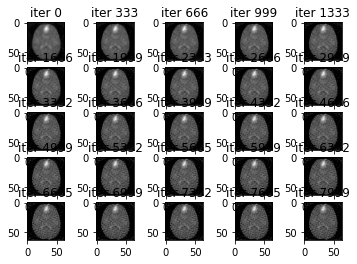

In [19]:
# Plot some iterations
idx=np.linspace(1,all_iter.shape[2],25)-1       # make 25 example iterations
red_iter=all_iter[:,:,tuple(idx.astype(int))]   # choose them from all iters
Tot=red_iter.shape[2]
Rows = Tot // 5 
if Tot % 5 != 0:
    Rows += 1
Position = range(1,Tot + 1) # Position index

fig = plt.figure()
for k in range(Tot):
  ax = fig.add_subplot(Rows,5,Position[k])
  ax.imshow((abs((red_iter[:,:,k])))); plt.title('iter {}'.format(idx[k].astype(int)))
  print(k)
plt.show()